## Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from datetime import datetime
import pickle, json, sys, os, glob
import pandas as pd
# from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.stats import chi2
from scipy import optimize

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from traitlets.config.loader import Config
from astropy.coordinates     import SkyCoord
from lstchain.io.config      import get_standard_config
from lstchain.io.io          import dl1_params_lstcam_key
from ctapipe.io              import read_table
import tables

# location of the scripts
sys.path.insert(0, os.getcwd() + "/../scripts/")
import auxiliar as aux
import geometry as geom
import lstpipeline
import plotting

# Some configurations

In [2]:
# Source specifications
source_name = "crab"

# Maybe we add a way to extract the run numbers we are interested in
run_number = 6172 # [6172, 6242, 6194, 6193, 15337, 15272, 15339, 15340]

# --- FIT PARAMETERS --- #
# hist_intensity_binning = np.logspace(np.log10(4), np.log10(6000), 400)   # intensity binning
limits_intensity = [316, 562]                  # limits for the fit
limit_intensity_extended = 60 # limits for the subsets

####################################
# --- POWER LAW PARAMETERS REF --- #
reference_normalization =  1.74 
reference_powerindex    = -2.23
####################################

# Threshold in statistics for the last subrun
statistics_threshold = 15000

# Paths to data and results

In [25]:
# Root path of this script
root = os.getcwd() + "/"
# Path to store the configuration file we are going to use
config_file = root + "config/standard_config.json"
# Path to store objects
root_objects = root + f"objects/"
# Data main directory
root_data = root + f"../../data/cherenkov_transparency_corrections/{source_name}/"
# Directory for the results of the fit of each run
root_results = root_objects + "results_fits/"
#Directory to store the scaled dl1 data
root_dl1 = root_objects + f"dl1_scaled/{run_number:05}/"

# STANDARD paths ---------
dl1_root = "/fefs/aswg/data/real/DL1/*/v0.*/tailcut84/"
rfs_root = "/fefs/aswg/data/models/AllSky/20230901_v0.10.4_allsky_base_prod/"
mcs_root = "/fefs/aswg/data/mc/DL2/AllSky/20230901_v0.10.4_allsky_base_prod/TestingDataset/"

# Create the paths that do not exist
for path in [os.path.dirname(config_file), root_objects, root_results, root_dl1]:
    if not os.path.exists(path):
        os.makedirs(os.path.join(path), exist_ok=True)

# Opening and storing configuration file

In [4]:
config_dict = get_standard_config()

# We select the heuristic flatfield option in the standard configuration
config_dict["source_config"]["LSTEventSource"]["use_flatfield_heuristic"] = True

with open(config_file, "w") as json_file:
    json.dump(config_dict, json_file)

# Finding the files that interest us
#### Extracting dl1 files and dl1 datachecks

In [5]:
# Getting coordinates of source
source_coords = SkyCoord.from_name(source_name)

dict_source = {
    "name"   : source_name,
    "coords" : source_coords,
    "ra"     : source_coords.ra.deg  * u.deg, # ra in degrees
    "dec"    : source_coords.dec.deg * u.deg, # dec in degrees
}

# We create a empty dictionary to store all the information needed inside
DICT = {}
for run in [run_number]:
    DICT[run] = {
        "run_num" : run,
        "errors"  : "", # log of errors trough the analysis
    }

DICT = lstpipeline.add_dl1_paths_to_dict(DICT, dl1_root)
DICT = lstpipeline.add_dl1_paths_to_dict(DICT, dl1_root, dchecking=True)


Adding dl1  data to dictionary...
...Finished adding dl1 data to dictionary

Adding dl1 datacheck data to dictionary...
...Finished adding dl1 data to dictionary


#### Then we read the observations information and also the selected nodes for MC and RFs and we add it to the DICT

In [6]:
for run in [run_number]:

    tab = read_table(DICT[run]["dchecks"]["runwise"], "/dl1datacheck/cosmics")
    
    # reading the variables
    _zd = 90 - np.rad2deg(np.array(tab["mean_alt_tel"]))
    _az = np.rad2deg(np.array(tab["mean_az_tel"]))
    _t_start   = tab["dragon_time"][0][0]
    _t_elapsed = np.array(tab["elapsed_time"])
    
    DICT[run]["time"] = {
        "tstart"   : _t_start,            # datetime object
        "telapsed" : np.sum(_t_elapsed),  # s
        "srunwise" : {
            "telapsed" : _t_elapsed,      # s      
        },
    }
    DICT[run]["pointing"] = {
        "zd" : np.mean(_zd),  # deg
        "az" : np.mean(_az),  # deg
        "srunwise" : {
            "zd" : _zd,       # deg
            "az" : _az,       # deg
        },
    }
    
# then we also select the RFs and MC files looking at the nodes available
DICT, dict_nodes = lstpipeline.add_mc_and_rfs_nodes(DICT, rfs_root, mcs_root, dict_source)

### Read datacheck
#### - The binning

In [7]:
reference_intensity = 10 ** ((np.log10(limits_intensity[0]) + np.log10(limits_intensity[1]))/2)
print(f"The intensity in the middle of the intensity range is {reference_intensity:.1f} p.e.")

########################################################
# Reading the binning from the datacheck ---------------
# Opening the corresponding datacheck
dcheck = DICT[run_number]["dchecks"]["runwise"]
run_dcheck  = tables.open_file(dcheck)

# Read the binning from the datacheck of the first subrun
dcheck_intensity_binning = np.array(run_dcheck.root.dl1datacheck.histogram_binning.col("hist_intensity")[0])
# Calculating the logarithmic center of each bin
dcheck_intensity_binning_centers = (dcheck_intensity_binning[:-1] * dcheck_intensity_binning[1:]) ** 0.5
# Calculating the width of each bin
dcheck_intensity_binning_widths = np.diff(dcheck_intensity_binning)
run_dcheck.close()

# Mask for the fitting region in the fits
mask_dcheck_bins_fit = ((dcheck_intensity_binning_centers >= limits_intensity[0]) & (dcheck_intensity_binning_centers <= limits_intensity[1]))

The intensity in the middle of the intensity range is 421.4 p.e.


#### - The data

In [8]:
##########################################################
# Reading the histogram from the datacheck ---------------
# Opening the corresponding datacheck
run_dcheck = tables.open_file(dcheck)
dcheck_hist_intensities = np.array(run_dcheck.root.dl1datacheck.cosmics.col("hist_intensity"))
run_dcheck.close()

# Converting from counts to rate per intensity unit (non-binning dependent quantity)
hist_rates       = [] # Array of histogram of rates for each subrun
hist_delta_rates = [] # The statistical error
for srun, dcheck_hist_intensity in enumerate(dcheck_hist_intensities):

    effective_time_srun = DICT[run_number]["time"]["srunwise"]["telapsed"][srun]
    
    hist_rates.append(              dcheck_hist_intensity  / effective_time_srun / dcheck_intensity_binning_widths)

    hist_delta_rates.append(np.sqrt(dcheck_hist_intensity) / effective_time_srun / dcheck_intensity_binning_widths)
    
# Number of events in last subrun
last_subrun_statistics = np.sum(dcheck_hist_intensities[-1])

# Subruns array 
sruns_array = np.arange(len(hist_rates))

#### - Fitting

In [9]:
# Performing the fit for each subrun
normalization_fit       = []
powerindex_fit          = []
delta_normalization_fit = []
delta_powerindex_fit    = []
pvalue_fit              = []
chi2_fit                = []
for srun, hist in enumerate(hist_rates):

    # Displacing the X-coordinates to the center of the fit, in order to decorrelate the fit
    xfit = dcheck_intensity_binning_centers[mask_dcheck_bins_fit] / reference_intensity
    yfit = hist_rates[srun][mask_dcheck_bins_fit]
    
    # Performing the fit
    params, pcov, info, _, _ = curve_fit(
        f     = geom.powerlaw,
        xdata = xfit,
        ydata = yfit,
        sigma = hist_delta_rates[srun][mask_dcheck_bins_fit],
        p0    = [reference_normalization, reference_powerindex],
        full_output = True,
    )
    
    normalization_fit.append(params[0])
    powerindex_fit.append(params[1])
    delta_normalization_fit.append(np.sqrt(pcov[0, 0]))
    delta_powerindex_fit.append(np.sqrt(pcov[1, 1]))
        
    _chi2 = np.sum(info['fvec'] ** 2)
    chi2_fit.append(_chi2)
    pvalue_fit.append(1 - chi2.cdf(_chi2, sum(mask_dcheck_bins_fit)))

    
# Convert to numpy arrays
normalization_fit       = np.array(normalization_fit)
powerindex_fit          = np.array(powerindex_fit)
delta_normalization_fit = np.array(delta_normalization_fit)
delta_powerindex_fit    = np.array(delta_powerindex_fit)
pvalue_fit              = np.array(pvalue_fit)
chi2_fit                = np.array(chi2_fit)

#### - Zenith corrections and light yield

Taking into account the logarithmic scale that is used, the light yield can be calculated with the following expression:\
\
$\qquad\qquad LY = \left(\frac{A_{fit}}{A_{ref}}\right)^{-\frac{1}{1+\alpha}}$\
\
The uncertainties have been calculated propagating the known ones.\
$\sigma_{LY} = \sqrt{\sum_x\left(\frac{\partial LY}{\partial x}\right)^2 \sigma_x^2}$\
Where:\
$\left(\frac{\partial LY}{\partial A}\right) = -\frac{1}{1+\alpha} A_{fit}^{\frac{1}{1+\alpha}} A_{ref}^{-\frac{2+\alpha}{1+\alpha}}$\
$\left(\frac{\partial LY}{\partial \alpha}\right) = -\frac{1}{(1+\alpha)^3}\left(\frac{A_{fit}}{A_{ref}}\right)^{-\frac{\alpha}{1+\alpha}}$\
\
So the final error will be:
\
$\sigma_{LY} = \frac{1}{1+\alpha}\sqrt{A_{fit}^{\frac{2}{1+\alpha}} A_{ref}^{-2\frac{2+\alpha}{1+\alpha}}\sigma_A^2 + \frac{1}{(1+\alpha)^4}\left(\frac{A_{fit}}{A_{ref}}\right)^{-\frac{2\alpha}{1+\alpha}}\sigma_{\alpha}^2}$

In [49]:
###############################
# --- PARAMETERS RELATION --- #
p0a, p0b, p0c = -0.44751321, 3.62502037, -1.43611437
p1a, p1b, p1c = -2.89253919, 0.99443581, -0.34013068
###############################

# Zenith corrections to the parameters
corr_normalization_fit = normalization_fit * geom.pol2(1, p0a, p0b, p0c) / geom.pol2(np.cos(np.deg2rad(DICT[run_number]["pointing"]["zd"])), p0a, p0b, p0c)
corr_powerindex_fit    = powerindex_fit    + geom.pol2(1, p1a, p1b, p1c) - geom.pol2(np.cos(np.deg2rad(DICT[run_number]["pointing"]["zd"])), p1a, p1b, p1c)

corr_delta_normalization_fit = delta_normalization_fit * geom.pol2(1, p0a, p0b, p0c) / geom.pol2(np.cos(np.deg2rad(DICT[run_number]["pointing"]["zd"])), p0a, p0b, p0c)
corr_delta_powerindex_fit    = delta_powerindex_fit

# Calculating the needed light yield
initial_light_yield = geom.calc_light_yield(reference_normalization, corr_normalization_fit, corr_powerindex_fit)

# def sigma_LY(A_fit, A_ref, a_fit, sigma_A, sigma_a):

#     dlydA = -1 / (1 + a_fit)      * A_fit ** (1 / (1 + a_fit))      * A_ref ** (-1 * (2 + a_fit) / (1 + a_fit))
#     dlyda = -1 / (1 + a_fit) ** 3 * A_fit ** (-a_fit / (1 + a_fit)) * A_ref ** (a_fit / (1 + a_fit))

#     return np.sqrt((dlydA) ** 2 * sigma_A ** 2, (dlyda) ** 2 * sigma_a ** 2)
    
# delta_initial_light_yield = sigma_LY(corr_powerindex_fit, corr_normalization_fit, reference_normalization, corr_delta_normalization_fit, corr_delta_powerindex_fit)

# Zenith correction of the reference (putting the reference in the zenith of the determined subrun)
corr_reference_normalization = reference_normalization / (geom.pol2(1, p0a, p0b, p0c) / geom.pol2(np.cos(np.deg2rad(DICT[run_number]["pointing"]["zd"])), p0a, p0b, p0c))
corr_reference_powerindex    = reference_powerindex    - (geom.pol2(1, p1a, p1b, p1c) - geom.pol2(np.cos(np.deg2rad(DICT[run_number]["pointing"]["zd"])), p1a, p1b, p1c))

print(f"The initial mean scaling factor obtained is {1 / np.mean(initial_light_yield):.2f}")

The initial mean scaling factor obtained is 1.46


#### - Defining scaling
In order to sample we will set two scalings for the conversion.

* $1/LY$ The ideal scaling needed. The case where no new pixels emerge on the cleaning (unrealistic).

* $\frac{1/LY +1}{2}$ Half of the anterior scaling, just for sampling reasons.

In [11]:
# Scalings to apply
upper_scaling = 1 / initial_light_yield
half_scaling  = 1 + (upper_scaling - 1) / 2

# In the case of the last subrun we use the last subrun statistics, because the lack of statistics
if last_subrun_statistics < statistics_threshold:
    upper_scaling[-1] = upper_scaling[-2]
    half_scaling[-1]  = half_scaling[-2]
    print(f"For last subrun using before subrun because of low statistics ({last_subrun_statistics}evs)")

#### <span style="color:orange"><<-----------------------------------------------------------------------------------------------\>></span>
#### <span style="color:orange"><<Some plots and checks that will not be included in the final script\>></span>
#### <span style="color:orange"><<-----------------------------------------------------------------------------------------------\>></span>

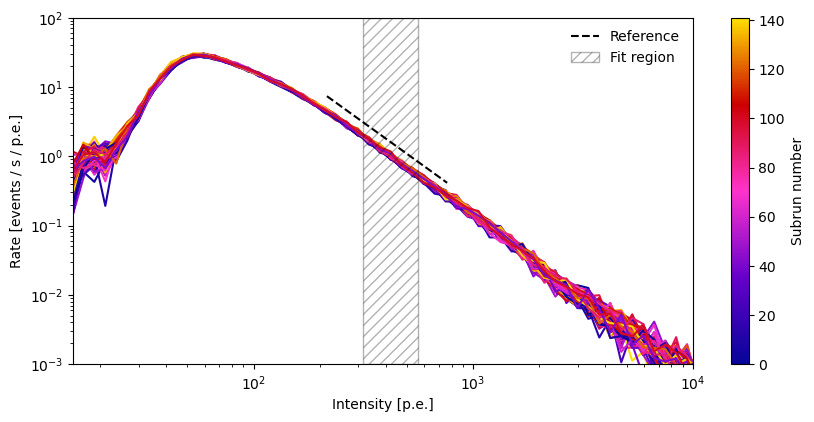

In [50]:
# Binning for the plots ------------------
bins_space = np.linspace(limits_intensity[0] - 100, limits_intensity[1] + 200, 100)

fig, ax = plt.subplots(1, 1, figsize=(10, 4.5))

colors = plotting.get_colors_multiplot(sruns_array)
for i in range(len(hist_rates)):
    ax.plot(dcheck_intensity_binning_centers, hist_rates[i], color=colors[i], zorder=np.random.rand())

cmap = plotting.create_cmap_from_colors(plotting.default_colors)
plotting.plot_colorbar(fig, ax, range(len(hist_rates)), cmap=cmap, label="Subrun number")

intensity_sample = np.linspace(limits_intensity[0] / 1.3, limits_intensity[1] * 1.5, 100)
ax.plot(bins_space, geom.powerlaw(bins_space / reference_intensity, corr_reference_normalization, corr_reference_powerindex), color="k", ls="--", label="Reference")
ax.axvspan(limits_intensity[0], limits_intensity[1], alpha=0.3, ls="-", facecolor="none", hatch="///", edgecolor="k", label="Fit region")

ax.set_xlabel("Intensity [p.e.]")
ax.set_ylabel("Rate [events / s / p.e.]")
ax.loglog()
ax.set_xlim(1.5e1, 1e4)
ax.set_ylim(1e-3, 1e2)
ax.legend(frameon=False)
# plt.savefig(f"plots/total.png", bbox_inches="tight")
plt.show()

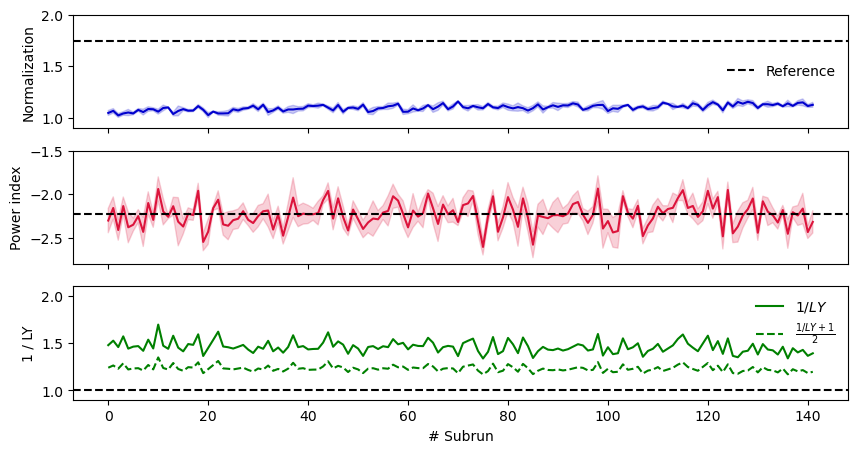

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

ax1.plot(sruns_array, corr_normalization_fit, color="mediumblue")
ax1.fill_between(sruns_array, corr_normalization_fit - corr_delta_normalization_fit, corr_normalization_fit + corr_delta_normalization_fit, color="mediumblue", alpha=0.2, ls="")


ax2.plot(sruns_array, corr_powerindex_fit, color="crimson")
ax2.fill_between(sruns_array, corr_powerindex_fit - corr_delta_powerindex_fit, corr_powerindex_fit + corr_delta_powerindex_fit, color="crimson", alpha=0.2, ls="")

ax3.plot(sruns_array, upper_scaling, color="g", label="$1/LY$")
ax3.plot(sruns_array, half_scaling, ls="--", color="g", label="$\\frac{1/LY + 1}{2}$")

ax1.axhline(reference_normalization, color="k", ls="--", label="Reference")
ax2.axhline(reference_powerindex, color="k", ls="--")
ax3.axhline(1, color="k", ls="--")

ax1.set_ylabel("Normalization")
ax2.set_ylabel("Power index")
ax3.set_ylabel("1 / LY")
ax3.set_xlabel("# Subrun")

ax1.set_ylim(0.9, 2)
ax2.set_ylim(-2.8, -1.5)
ax3.set_ylim(0.9, 2.1)
ax1.legend(frameon=False)
ax3.legend(frameon=False)

# plt.savefig(f"plots/total.png", bbox_inches="tight")
plt.show()

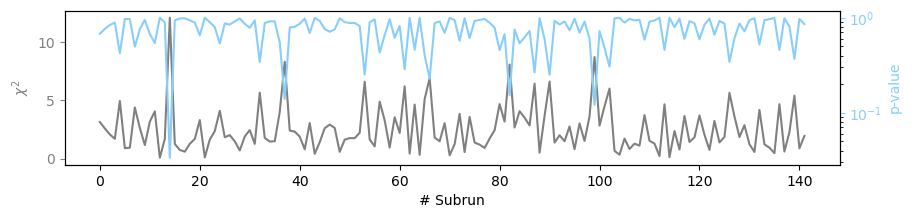

In [14]:
fig, ax = plt.subplots(figsize=(10, 2), sharex=True)
axt = ax.twinx()

p1, = ax.plot(sruns_array, chi2_fit, color="gray")
p2, = axt.plot(sruns_array, pvalue_fit, ls="-", color="lightskyblue")

ax.set_ylabel("$\chi^2$")
axt.set_ylabel("p-value")
ax.set_xlabel("# Subrun")
axt.set_yscale("log")

ax.yaxis.label.set_color(p1.get_color())
axt.yaxis.label.set_color(p2.get_color())
ax.tick_params(axis='y', colors=p1.get_color())
axt.tick_params(axis='y', colors=p2.get_color())

# plt.savefig(f"plots/total.png", bbox_inches="tight")
plt.show()

#### Create a dictionary to store all the information

In [15]:
# Empty dict to store the information
dict_results = { 
    "run": run_number,
    "filenames": {},
    "normalization":       {"default": {}, "upper": {}, "half": {}, "final": {}},
    "delta_normalization": {"default": {}, "upper": {}, "half": {}, "final": {}},
    "powerindex":          {"default": {}, "upper": {}, "half": {}, "final": {}},
    "delta_powerindex":    {"default": {}, "upper": {}, "half": {}, "final": {}},
    "light_yield":         {"default": {}, "upper": {}, "half": {}, "final": {}},
    "chi2":                {"default": {}, "upper": {}, "half": {}, "final": {}},
    "pvalue":              {"default": {}, "upper": {}, "half": {}, "final": {}},
    "final_scaling": {},
}

# Filling with the information we have
for srun in sruns_array:
    dict_results["normalization"]["default"]       = corr_normalization_fit
    dict_results["delta_normalization"]["default"] = corr_delta_normalization_fit
    dict_results["powerindex"]["default"]          = corr_powerindex_fit
    dict_results["delta_powerindex"]["default"]    = corr_delta_powerindex_fit
    dict_results["light_yield"]["default"]         = initial_light_yield
    dict_results["chi2"]["default"]                = chi2_fit
    dict_results["pvalue"]["default"]              = pvalue_fit

### Performing for each subrun


Processing subrun 0/142
Running lstchain_dl1ab... scale: 1.48
Pedestal cleaning
Fraction of Cat_A pixel cleaning thresholds above Cat_A picture thr.:0.030
Tailcut clean with pedestal threshold config used:{'picture_thresh': 8, 'boundary_thresh': 4, 'sigma': 2.5, 'keep_isolated_pixels': False, 'min_number_picture_neighbors': 2, 'use_only_main_island': False, 'delta_time': 2}
Using dynamic cleaning for events with average size of the 3 most brighest pixels > 267 p.e
Remove from image pixels which have charge below = 0.03 * average size
Running lstchain_dl1ab... scale: 1.24
Pedestal cleaning
Fraction of Cat_A pixel cleaning thresholds above Cat_A picture thr.:0.030
Tailcut clean with pedestal threshold config used:{'picture_thresh': 8, 'boundary_thresh': 4, 'sigma': 2.5, 'keep_isolated_pixels': False, 'min_number_picture_neighbors': 2, 'use_only_main_island': False, 'delta_time': 2}
Using dynamic cleaning for events with average size of the 3 most brighest pixels > 267 p.e
Remove from im

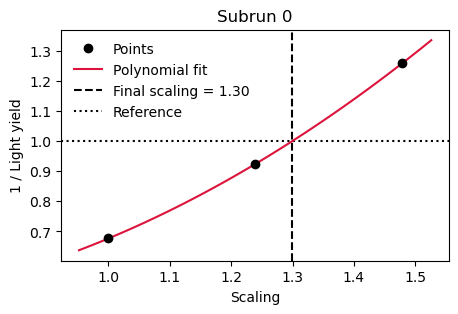

Output file /fefs/aswg/workspace/juan.jimenez/cherenkov_transparency_corrections/data_processing/objects/dl1_scaled/06172/dl1_LST-1.Run06172.0000.h5 already exists

Processing subrun 1/142
Running lstchain_dl1ab... scale: 1.53
Pedestal cleaning
Fraction of Cat_A pixel cleaning thresholds above Cat_A picture thr.:0.029
Tailcut clean with pedestal threshold config used:{'picture_thresh': 8, 'boundary_thresh': 4, 'sigma': 2.5, 'keep_isolated_pixels': False, 'min_number_picture_neighbors': 2, 'use_only_main_island': False, 'delta_time': 2}
Using dynamic cleaning for events with average size of the 3 most brighest pixels > 267 p.e
Remove from image pixels which have charge below = 0.03 * average size
Running lstchain_dl1ab... scale: 1.26
Pedestal cleaning
Fraction of Cat_A pixel cleaning thresholds above Cat_A picture thr.:0.029
Tailcut clean with pedestal threshold config used:{'picture_thresh': 8, 'boundary_thresh': 4, 'sigma': 2.5, 'keep_isolated_pixels': False, 'min_number_picture_neigh

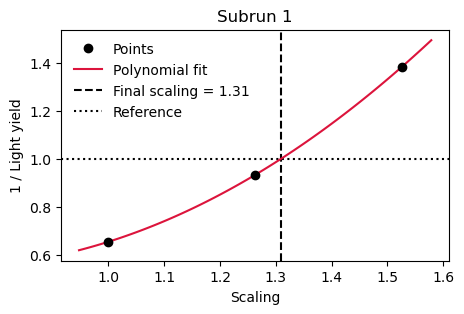

Pedestal cleaning
Fraction of Cat_A pixel cleaning thresholds above Cat_A picture thr.:0.029
Tailcut clean with pedestal threshold config used:{'picture_thresh': 8, 'boundary_thresh': 4, 'sigma': 2.5, 'keep_isolated_pixels': False, 'min_number_picture_neighbors': 2, 'use_only_main_island': False, 'delta_time': 2}
Using dynamic cleaning for events with average size of the 3 most brighest pixels > 267 p.e
Remove from image pixels which have charge below = 0.03 * average size

Processing subrun 2/142
Running lstchain_dl1ab... scale: 1.46
Pedestal cleaning
Fraction of Cat_A pixel cleaning thresholds above Cat_A picture thr.:0.029
Tailcut clean with pedestal threshold config used:{'picture_thresh': 8, 'boundary_thresh': 4, 'sigma': 2.5, 'keep_isolated_pixels': False, 'min_number_picture_neighbors': 2, 'use_only_main_island': False, 'delta_time': 2}
Using dynamic cleaning for events with average size of the 3 most brighest pixels > 267 p.e
Remove from image pixels which have charge below = 0

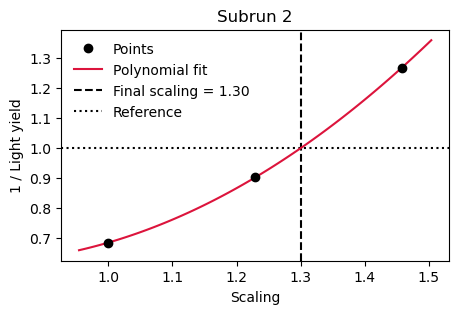

Pedestal cleaning
Fraction of Cat_A pixel cleaning thresholds above Cat_A picture thr.:0.029
Tailcut clean with pedestal threshold config used:{'picture_thresh': 8, 'boundary_thresh': 4, 'sigma': 2.5, 'keep_isolated_pixels': False, 'min_number_picture_neighbors': 2, 'use_only_main_island': False, 'delta_time': 2}
Using dynamic cleaning for events with average size of the 3 most brighest pixels > 267 p.e
Remove from image pixels which have charge below = 0.03 * average size

Processing subrun 3/142
Running lstchain_dl1ab... scale: 1.57
Pedestal cleaning
Fraction of Cat_A pixel cleaning thresholds above Cat_A picture thr.:0.027
Tailcut clean with pedestal threshold config used:{'picture_thresh': 8, 'boundary_thresh': 4, 'sigma': 2.5, 'keep_isolated_pixels': False, 'min_number_picture_neighbors': 2, 'use_only_main_island': False, 'delta_time': 2}
Using dynamic cleaning for events with average size of the 3 most brighest pixels > 267 p.e
Remove from image pixels which have charge below = 0


KeyboardInterrupt



In [19]:
# Processing subrun by subrun
for srun in sruns_array:

    print(f"\nProcessing subrun {srun}/{len(sruns_array)}")
    
    input_fname = DICT[run_number]["dl1a"]["srunwise"][srun]

    # Generating the scaled files
    output_fname_upper = root_objects + f"tmp_dl1_srunwise_upper_scaled.h5"
    output_fname_half  = root_objects + f"tmp_dl1_srunwise_half_scaled.h5"

    for scale, output_fname in zip([upper_scaling[srun], half_scaling[srun]], [output_fname_upper, output_fname_half]):
        
        # If the file already exists we delete it
        if os.path.exists(output_fname):
            os.remove(output_fname)
        
        # If scale is greater than 1 we select a range lower than the original one
        # Otherwise we select a range higher than the original one
        if scale > 1:
            dl1_selected_range = f"{limit_intensity_extended:.2f},{limits_intensity[1]:.2f}"
        else:
            dl1_selected_range = f"{limits_intensity[0]:.2f},inf"

        print(f"Running lstchain_dl1ab... scale: {scale:.2f}")

        !lstchain_dl1ab \
        --input-file $input_fname \
        --output-file $output_fname \
        --config $config_file \
        --no-image \
        --light-scaling $scale \
        --intensity-range $dl1_selected_range

    # Reading the files
    for id_side, output_fname in zip(["upper", "half"], [output_fname_upper, output_fname_half]):

        dl1b_file = tables.open_file(output_fname)
        _hist_intensity, _ = np.histogram(dl1b_file.root.dl1.event.telescope.parameters.LST_LSTCam.col("intensity"), bins=dcheck_intensity_binning)
        dl1b_file.close()

        
        # Calculating the non binning dependent transformation
        effective_time_srun = DICT[run_number]["time"]["srunwise"]["telapsed"][srun]
        rates       = np.array(_hist_intensity) / effective_time_srun / dcheck_intensity_binning_widths
        delta_rates = np.sqrt(_hist_intensity)  / effective_time_srun / dcheck_intensity_binning_widths

        # Displacing the X-coordinates to the center of the fit, in order to decorrelate the fit
        xfit = dcheck_intensity_binning_centers[mask_dcheck_bins_fit] / reference_intensity
        yfit = rates[mask_dcheck_bins_fit]
        
        # Performing the fit
        params, pcov, info, _, _ = curve_fit(
            f     = geom.powerlaw,
            xdata = xfit,
            ydata = yfit,
            sigma = delta_rates[mask_dcheck_bins_fit],
            p0    = [reference_normalization, reference_powerindex],
            full_output = True,
        )
        
        norm         = params[0]
        pindex       = params[1]
        delta_norm   = np.sqrt(pcov[0, 0])
        delta_pindex = np.sqrt(pcov[1, 1])
        _chi2        = np.sum(info['fvec'] ** 2)
        pvalue       = 1 - chi2.cdf(_chi2, sum(mask_dcheck_bins_fit))

        # Zenith corrections to the parameters
        corr_norm         = norm       * geom.pol2(1, p0a, p0b, p0c) / geom.pol2(np.cos(np.deg2rad(DICT[run_number]["pointing"]["zd"])), p0a, p0b, p0c)
        corr_pindex       = pindex     + geom.pol2(1, p1a, p1b, p1c) - geom.pol2(np.cos(np.deg2rad(DICT[run_number]["pointing"]["zd"])), p1a, p1b, p1c)
        corr_delta_norm   = delta_norm * geom.pol2(1, p0a, p0b, p0c) / geom.pol2(np.cos(np.deg2rad(DICT[run_number]["pointing"]["zd"])), p0a, p0b, p0c)
        corr_delta_pindex = delta_pindex
        
        # Calculating the needed light yield
        light_yield = geom.calc_light_yield(reference_normalization, corr_norm, corr_pindex)

        # Storing the results
        dict_results["normalization"][id_side][srun]       = corr_norm
        dict_results["delta_normalization"][id_side][srun] = corr_delta_norm
        dict_results["powerindex"][id_side][srun]          = corr_pindex
        dict_results["delta_powerindex"][id_side][srun]    = corr_delta_pindex
        dict_results["light_yield"][id_side][srun]         = light_yield
        dict_results["chi2"][id_side][srun]                = _chi2
        dict_results["pvalue"][id_side][srun]              = pvalue
        
    # In the case of the last subrun we use the last subrun statistics, because the lack of statistics
    if last_subrun_statistics < statistics_threshold:

        final_scaling = final_scaling
        print(f"For last subrun using before subrun because of low statistics ({last_subrun_statistics}evs)")

    else:

        # Now putting all together, upper and half
        points_scaling     = np.array([1, half_scaling[srun], upper_scaling[srun]])
        points_light_yield = np.array([1/upper_scaling[srun], dict_results["light_yield"]["half"][srun], dict_results["light_yield"]["upper"][srun]])
    
        # And fitting to a 2nd degree polynomial
        pol2_scaling = np.poly1d(np.polyfit(points_scaling, points_light_yield, 2))
    
        # And finding the final scaling
        final_scaling = optimize.root(pol2_scaling - 1, x0=half_scaling[srun]).x[0]

        ############################################
        fig, ax = plt.subplots(1, 1, figsize=(5, 3))
        ax.plot(points_scaling, points_light_yield, "o", color="k", label="Points", zorder=10)
        size_points = max(points_scaling) - min(points_scaling)
        sample_scaling = np.linspace(min(points_scaling) - 0.1 * size_points, max(points_scaling) + 0.1 * size_points, 100)
        ax.plot(sample_scaling, pol2_scaling(sample_scaling), color="crimson", ls="-", label="Polynomial fit", zorder=5)
        ax.axvline(final_scaling, color="k", ls="--", label=f"Final scaling = {final_scaling:.2f}")
        ax.axhline(1, color="k", ls=":", label="Reference")
        ax.set_xlabel("Scaling")
        ax.set_ylabel("1 / Light yield")
        ax.legend(frameon=False)
        ax.set_title(f"Subrun {srun}")
        plt.show()
        ############################################

    dict_results["final_scaling"][srun] = final_scaling
    
    output_final_fname = root_data + f"dl1_scaled/{run_number:05}/" + os.path.basename(DICT[run_number]["dl1a"]["srunwise"][srun])
    dict_results["filenames"][srun] = output_fname

    !lstchain_dl1ab \
    --input-file $input_fname \
    --output-file $output_final_fname \
    --config $config_file \
    --no-image \
    --light-scaling $final_scaling

#### The crosscheck
Reading now the already processed runs and run the fit in order to see if the correction lead to a almost zero light yield

In [55]:
root_dl1b_scaled = root_data + f"dl1_scaled/{run_number:05}/dl1_LST-1.Run?????.????.h5"
dl1_files = np.sort(glob.glob(root_dl1b_scaled))

for srun, file in enumerate(dl1_files):
    dl1b_file = tables.open_file(file)
    final_hist_intensity, _ = np.histogram(dl1b_file.root.dl1.event.telescope.parameters.LST_LSTCam.col("intensity"), bins=dcheck_intensity_binning)
    dl1b_file.close()
    
    # Converting from counts to rate per intensity unit (non-binning dependent quantity)
    final_hist_rates       = [] # Array of histogram of rates for each subrun
    final_hist_delta_rates = [] # The statistical error
    
    effective_time_srun = DICT[run_number]["time"]["srunwise"]["telapsed"][srun]
    
    final_hist_rates.append(              dcheck_hist_intensity  / effective_time_srun / dcheck_intensity_binning_widths)
    final_hist_delta_rates.append(np.sqrt(dcheck_hist_intensity) / effective_time_srun / dcheck_intensity_binning_widths)
    
    # Performing the fit for each subrun
    final_normalization_fit       = []
    final_powerindex_fit          = []
    final_delta_normalization_fit = []
    final_delta_powerindex_fit    = []
    final_pvalue_fit              = []
    final_chi2_fit                = []
    for srun, hist in enumerate(hist_rates):
    
        # Displacing the X-coordinates to the center of the fit, in order to decorrelate the fit
        xfit = dcheck_intensity_binning_centers[mask_dcheck_bins_fit] / reference_intensity
        yfit = hist_rates[srun][mask_dcheck_bins_fit]
        
        # Performing the fit
        params, pcov, info, _, _ = curve_fit(
            f     = geom.powerlaw,
            xdata = xfit,
            ydata = yfit,
            sigma = hist_delta_rates[srun][mask_dcheck_bins_fit],
            p0    = [reference_normalization, reference_powerindex],
            full_output = True,
        )
        
        final_normalization_fit.append(params[0])
        final_powerindex_fit.append(params[1])
        final_delta_normalization_fit.append(np.sqrt(pcov[0, 0]))
        final_delta_powerindex_fit.append(np.sqrt(pcov[1, 1]))
            
        _chi2 = np.sum(info['fvec'] ** 2)
        final_chi2_fit.append(_chi2)
        final_pvalue_fit.append(1 - chi2.cdf(_chi2, sum(mask_dcheck_bins_fit)))
    
        
    # Convert to numpy arrays
    final_normalization_fit       = np.array(final_normalization_fit)
    final_powerindex_fit          = np.array(final_powerindex_fit)
    final_delta_normalization_fit = np.array(final_delta_normalization_fit)
    final_delta_powerindex_fit    = np.array(final_delta_powerindex_fit)
    final_pvalue_fit              = np.array(final_pvalue_fit)
    final_chi2_fit                = np.array(final_chi2_fit)

    # Zenith corrections to the parameters
    corr_final_normalization_fit = final_normalization_fit * geom.pol2(1, p0a, p0b, p0c) / geom.pol2(np.cos(np.deg2rad(DICT[run_number]["pointing"]["zd"])), p0a, p0b, p0c)
    corr_final_powerindex_fit    = final_powerindex_fit    + geom.pol2(1, p1a, p1b, p1c) - geom.pol2(np.cos(np.deg2rad(DICT[run_number]["pointing"]["zd"])), p1a, p1b, p1c)
    
    corr_final_delta_normalization_fit = final_delta_normalization_fit * geom.pol2(1, p0a, p0b, p0c) / geom.pol2(np.cos(np.deg2rad(DICT[run_number]["pointing"]["zd"])), p0a, p0b, p0c)
    corr_final_delta_powerindex_fit    = final_delta_powerindex_fit
    
    # Calculating the needed light yield
    final_light_yield = geom.calc_light_yield(reference_normalization, corr_final_normalization_fit, corr_final_powerindex_fit)
    
    final_scalings = 1 / final_light_yield

    # Storing the results
    dict_results["normalization"]["final"][srun]       = corr_final_normalization_fit
    dict_results["delta_normalization"]["final"][srun] = corr_final_delta_normalization_fit
    dict_results["powerindex"]["final"][srun]          = corr_final_powerindex_fit
    dict_results["delta_powerindex"]["final"][srun]    = corr_final_delta_powerindex_fit
    dict_results["light_yield"]["final"][srun]         = final_light_yield
    dict_results["chi2"]["final"][srun]                = final_chi2_fit
    dict_results["pvalue"]["final"][srun]              = final_pvalue_fit

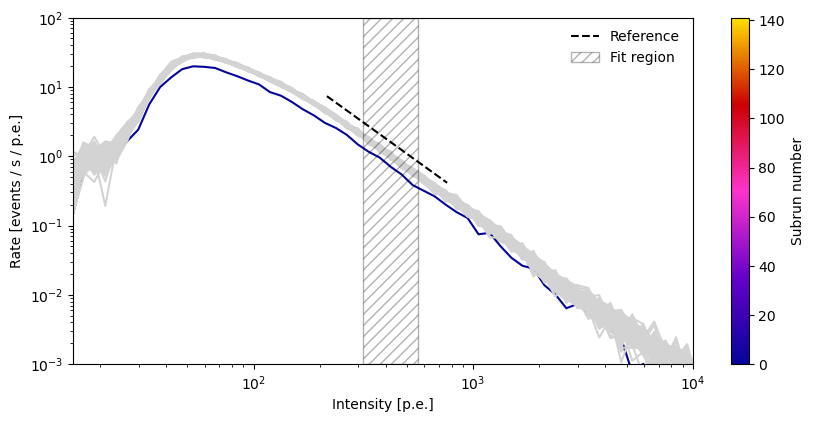

In [60]:
# Binning for the plots ------------------
bins_space = np.linspace(limits_intensity[0] - 100, limits_intensity[1] + 200, 100)

fig, ax = plt.subplots(1, 1, figsize=(10, 4.5))

colors = plotting.get_colors_multiplot(sruns_array)
for i in range(len(hist_rates)):
    ax.plot(dcheck_intensity_binning_centers, hist_rates[i], color="lightgray", zorder=np.random.rand())

for i in range(len(final_hist_rates)):
    ax.plot(dcheck_intensity_binning_centers, final_hist_rates[i], color=colors[i], zorder=np.random.rand())

cmap = plotting.create_cmap_from_colors(plotting.default_colors)
plotting.plot_colorbar(fig, ax, range(len(hist_rates)), cmap=cmap, label="Subrun number")

intensity_sample = np.linspace(limits_intensity[0] / 1.3, limits_intensity[1] * 1.5, 100)
ax.plot(bins_space, geom.powerlaw(bins_space / reference_intensity, corr_reference_normalization, corr_reference_powerindex), color="k", ls="--", label="Reference")
ax.axvspan(limits_intensity[0], limits_intensity[1], alpha=0.3, ls="-", facecolor="none", hatch="///", edgecolor="k", label="Fit region")

ax.set_xlabel("Intensity [p.e.]")
ax.set_ylabel("Rate [events / s / p.e.]")
ax.loglog()
ax.set_xlim(1.5e1, 1e4)
ax.set_ylim(1e-3, 1e2)
ax.legend(frameon=False)
# plt.savefig(f"plots/total.png", bbox_inches="tight")
plt.show()

## Storing the results of the fits in a file for each run

In [ ]:
dict_fname = root_results + f"results_run_{run_number}.pkl"

# Saving the objects
with open(dict_fname, 'wb') as f:
    pickle.dump(dict_results, f, pickle.HIGHEST_PROTOCOL)
    
# Reading the object
with open(dict_fname, 'rb') as f:
    dict_results = pickle.load(f)

## Some plots for checking the results

In [ ]:
# Reading the full set of scalings from the results
final_scalings = np.array([dict_results["final_scaling"][srun] for srun in dict_results["final_scaling"].keys()])

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

ax1.plot(sruns, corr_norm_srun, color="mediumblue")
ax2.plot(sruns, 1/light_yield_srun, color="crimson")
ax2.plot(sruns, mid_scaling, ls="--", color="crimson", label="$1 + \\frac{1/LY - 1}{2}$")
ax3.plot(sruns, (final_scalings - 1 ) * 100, color="k")

ax1.axhline(norm_ref, color="k", ls="--", label="Reference")
ax2.axhline(1, color="k", ls="--")
ax3.axhline(0, color="k", ls="--")

ax1.set_ylabel("Normalization")
ax2.set_ylabel("1 / light yield")
ax3.set_ylabel("Final scaling %")
ax3.set_xlabel("# Subrun")

ax1.set_ylim(1.2, 2)
ax2.set_ylim(0.9, 1.3)
ax3.set_ylim(-5, 15)
ax1.legend(frameon=False)

# plt.savefig(f"plots/total.png", bbox_inches="tight")
plt.show()